# Projekt in Vorlesung Data Analytics : Tankpreis-Änderung

<b>DPT2 im Wintersemester 2025/2026 </b>

Teilnehmer:
- Giuliano, Donato: 1003007
- Kickel, Marvin: 20049957
- Klempar, Sheyenne: 1003122

## Datentransformation

Anforderung 1

Führen Sie zwei DataFrames mit merge zusammen - wenn Sie nur ein DataFrame haben, können Sie z.B. eine Konvertierungstabelle erstellen und anspielen (z.B. Land zu Kontinent);

Idee: EUR/USD-Wechselkurs mit dem Brentpreis über das Datum verbinden

Ziel: Zusammenhang zwischen beiden Datensätzen untersuchen: hängt ein schwächerer Euro mit steigenden Ölpreisen zusammen?

Zusammenführen des Wechselkurses und des Brentpreises mit einem Merge über das Datum

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importieren der Funktionen zum Laden der DataFrames
from data.data_retrevial.ecb_data import get_ecb_values
from data.data_retrevial.oil_data import get_oil_prices
from data.data_retrevial.tankerkoenig_historic import get_tankerkoenig_historic

# Erstellen der DataFrames durch Aufruf der Ladefunktionen
oil_data_df = get_oil_prices()
ecb_data_df = get_ecb_values()
tankdata_short_df = get_tankerkoenig_historic(
    start_date_str="2025-08-01",
    end_date_str="2025-09-30",
    resolve_uuids=True
)

ecb_data_df['Date'] = pd.to_datetime(ecb_data_df['Date'])
ecb_data_df_interpolated = ecb_data_df.set_index('Date').asfreq('D').interpolate().reset_index()

oil_data_df['Date'] = pd.to_datetime(oil_data_df['Date'])
oil_data_df_interpolated = oil_data_df.set_index('Date').asfreq('D').interpolate().reset_index()

#Merged DF benutzt hier interpolierte Öl- und Wechselkursdaten

ecb_oil_merged_df = pd.merge(ecb_data_df_interpolated, oil_data_df_interpolated, on='Date', how='inner')
print(ecb_oil_merged_df.head(10))
print(ecb_oil_merged_df.columns)




        Date  USD_per_EUR      Price
0 1999-01-04       1.1789  10.940000
1 1999-01-05       1.1790  10.300000
2 1999-01-06       1.1743  10.670000
3 1999-01-07       1.1632  11.080000
4 1999-01-08       1.1659  11.700000
5 1999-01-09       1.1629  11.823333
6 1999-01-10       1.1599  11.946667
7 1999-01-11       1.1569  12.070000
8 1999-01-12       1.1520  11.780000
9 1999-01-13       1.1744  10.900000
Index(['Date', 'USD_per_EUR', 'Price'], dtype='object')


Erstellung eines Line-Charts, um den Zusammenhang zwischen Wechselkurs und Ölpreis über die Zeit hinweg zu beobachten:


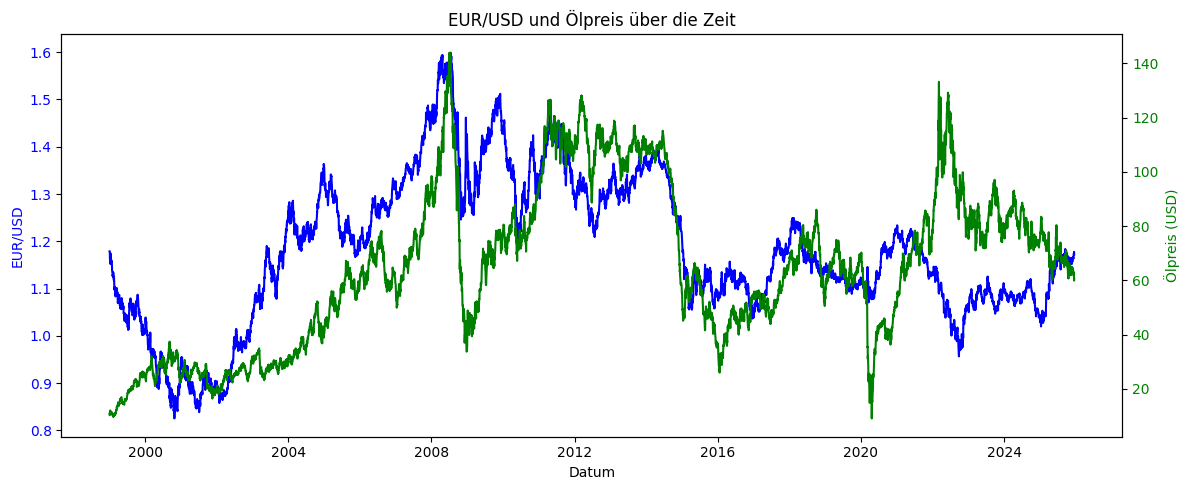

In [3]:
fig, ax1 = plt.subplots(figsize=(12,5))

# Erste Achse für EUR/USD
ax1.plot(ecb_oil_merged_df["Date"], ecb_oil_merged_df["USD_per_EUR"], color="blue", label="EUR/USD")
ax1.set_xlabel("Datum")
ax1.set_ylabel("EUR/USD", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Zweite Achse für Ölpreis
ax2 = ax1.twinx()
ax2.plot(ecb_oil_merged_df["Date"], ecb_oil_merged_df["Price"], color="green", label="Ölpreis (USD)")
ax2.set_ylabel("Ölpreis (USD)", color="green")
ax2.tick_params(axis='y', labelcolor="green")

plt.title("EUR/USD und Ölpreis über die Zeit")
fig.tight_layout()
plt.show()

Anforderung 2: Erstellen einer Pivot-Tabelle

Wir erstellen eine Pivot-Tabelle mit dem täglichen Durchschnitt der Tankpreise (Diesel, E5, E10) und dem Rohölpreis in EUR.
Ziel ist es, einen möglichen Zusammenhang bzw. eine Korrelation zwischen den deutschen Tankpreisen und dem internationalen Rohölpreis zu untersuchen.

Zunächst bereiten wir die Tankdaten auf. Da der Datensatz für einen Monat rund 14 Millionen Zeilen umfasst, ist eine Filterung erforderlich, um die Analyse handhabbar zu machen. Wir betrachten daher zunächst nur Tankstellen die einer bestimmten PLZ zugeordnet sind. Außerdem liegen mehrere Messungen pro Tag vor, daher aggregieren wir die Daten. Wir wollen eine Entscheidung treffen, ob sich der Median oder der Mittelwert besser für die Berechnung eignet. 

Des Weiteren haben wir die Ölpreise und Wechselkursdaten für die Wochenenden interpoliert, da die offiziellen Daten nur für Werktage bereitgestellt werden. Die interpolierten DataFrames wurden anfangs schon definiert.

In [4]:
df_filtered = tankdata_short_df[tankdata_short_df['PLZ'] == '70327']
df_filtered['date'] = df_filtered['Datum_Uhrzeit'].dt.date
df_daily_median = df_filtered.groupby('date')[['Diesel', 'E5', 'E10']].median().reset_index()
df_daily_mean = df_filtered.groupby('date')[['Diesel', 'E5', 'E10']].mean().reset_index()
print(df_daily_median.head(10))
print(df_daily_mean.head(10))

         date  Diesel     E5    E10
0  2025-08-01   1.599  1.699  1.639
1  2025-08-02   1.589  1.699  1.639
2  2025-08-03   1.589  1.699  1.639
3  2025-08-04   1.579  1.689  1.629
4  2025-08-05   1.579  1.679  1.619
5  2025-08-06   1.569  1.679  1.619
6  2025-08-07   1.569  1.699  1.639
7  2025-08-08   1.559  1.679  1.619
8  2025-08-09   1.559  1.689  1.629
9  2025-08-10   1.559  1.679  1.619
         date    Diesel        E5       E10
0  2025-08-01  1.605708  1.715149  1.655770
1  2025-08-02  1.599855  1.712816  1.653605
2  2025-08-03  1.602309  1.706647  1.647456
3  2025-08-04  1.589524  1.705126  1.645335
4  2025-08-05  1.586443  1.695534  1.635648
5  2025-08-06  1.573457  1.693743  1.634029
6  2025-08-07  1.574916  1.713764  1.653764
7  2025-08-08  1.566451  1.694294  1.634817
8  2025-08-09  1.569190  1.699949  1.640582
9  2025-08-10  1.571993  1.696299  1.636810


C:\Users\donat\AppData\Local\Temp\ipykernel_66000\1144521720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df_filtered['Datum_Uhrzeit'].dt.date


Wir haben uns dazu entschieden, mit dem Median zu arbeiten, da wir bei unserem Datensatz viele Ausreißer haben (morgens oder nachts deutlich teurer als tagsüber). Außerdem liegt bei den Tankpreisen eine rechtsschiefe Verteilung vor (viele Werte unten und wenige Ausreißer oben). Das bedeutet, dass der Mittelwert nach oben hin verzerrt wird. Der Median hingegen bleibt stabil und ist für unsere Analysen aussagekräftiger.

Nun wollen wir den Ölpreis in EUR berechnen und ihn mit den Tagesdurchschnittspreisen aus den Tankdaten zusammenführen und letztendlich die Pivot-Tabelle erstellen.

In [5]:
ecb_oil_merged_df['Oil_Price_EUR'] = ecb_oil_merged_df['Price'] / ecb_oil_merged_df['USD_per_EUR']

# Create a 'date' column from the merged 'Date' column so types match df_daily_median
ecb_oil_merged_df['date'] = pd.to_datetime(ecb_oil_merged_df['Date']).dt.date

# Merge median daily tank prices with oil price in EUR
df_daily_all = df_daily_median.merge(ecb_oil_merged_df[['date','Oil_Price_EUR']], on='date', how='left')

pivot = df_daily_all.pivot_table(
    index='date',
    values=['Diesel','E5','E10','Oil_Price_EUR'],
    aggfunc='median'
)

pivot.head(10)

,Diesel,E10,E5,Oil_Price_EUR
date,,,,
2025-08-01,1.599,1.639,1.699,61.864258
2025-08-02,1.589,1.639,1.699,61.286475
2025-08-03,1.589,1.639,1.699,60.714079
2025-08-04,1.579,1.629,1.689,60.146995
2025-08-05,1.579,1.619,1.679,59.882210
2025-08-06,1.569,1.619,1.679,58.574629
2025-08-07,1.569,1.639,1.699,57.536717
2025-08-08,1.559,1.619,1.679,57.666552
2025-08-09,1.559,1.629,1.689,57.763904


Nun wollen wir eine Visualisierung erstellen, um den Zusammenhang zwischen den täglichen Tankpreisen (Diesel, E5 und E10) und dem Rohölpreis in Euro darzustellen. Die Tankpreise werden auf der linken y-Achse abgebildet, während der Rohölpreis auf einer zweiten y-Achse dargestellt wird. So können wir Trends und mögliche Korrelationen zwischen den Kraftstoffpreisen und dem Rohölpreis über den betrachteten Zeitraum leicht erkennen.

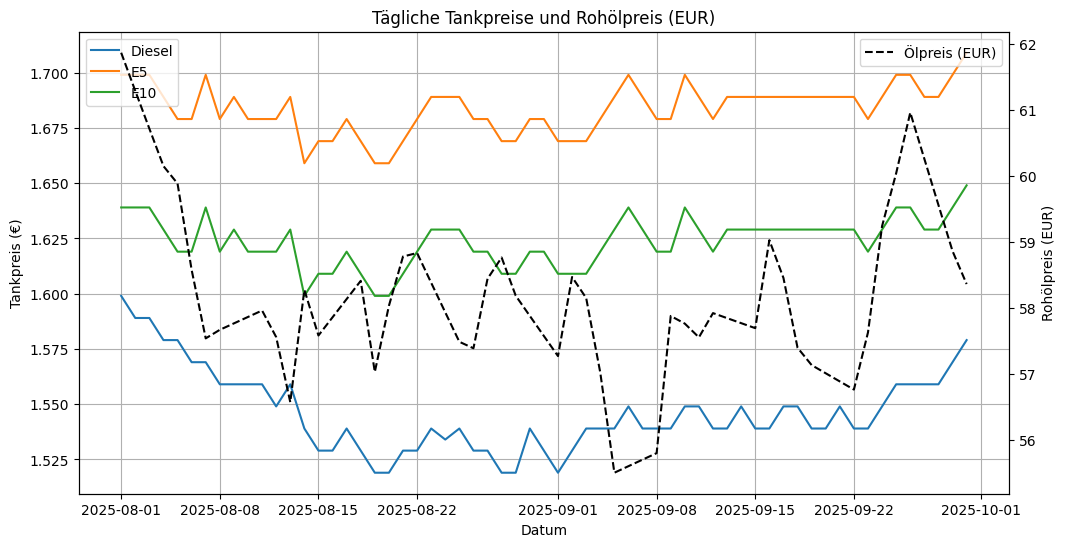

In [6]:
plt.figure(figsize=(12,6))

# Linien für Tankpreise
plt.plot(df_daily_all['date'], df_daily_all['Diesel'], label='Diesel')
plt.plot(df_daily_all['date'], df_daily_all['E5'], label='E5')
plt.plot(df_daily_all['date'], df_daily_all['E10'], label='E10')

# Linie für Ölpreis in EUR (zweite Achse)
plt.ylabel("Tankpreis (€)")
plt.xlabel("Datum")
plt.title("Tägliche Tankpreise und Rohölpreis (EUR)")
plt.grid(True)
plt.legend(loc='upper left')

# Zweite Achse für Ölpreis
ax2 = plt.gca().twinx()
ax2.plot(df_daily_all['date'], df_daily_all['Oil_Price_EUR'], color='black', linestyle='--', label='Ölpreis (EUR)')
ax2.set_ylabel("Rohölpreis (EUR)")
ax2.legend(loc='upper right')

plt.show()

Ergebnis: Grundsätzlich erkennt man, dass die Tankpreise und der Rohölpreis korreliert. Auch wenn die Tankpreise nicht direkt auf die Rohölpreise reagieren, kann man gewisse Trends erkennen. Anzumerken ist, dass nur ein Zeitraum von 2 Monaten betrachtet wird. Für eine aussagekräftigere Analyse, sollte ein größerer Zeitraum betrachtet werden. Im nächsten Schritt soll die Korrelation zwischen den Tankpreisen und dem Rohölpreis berechnet werden.

Nun wollen wir schließlich eine detaillierte Visualisierung erstellen, um den Zusammenhang zwischen den täglichen Tankpreisen (Diesel, E5 und E10) und dem Rohölpreis in Euro zu untersuchen. Dazu werden die Daten zunächst in ein „long format“ überführt, sodass jede Kraftstoffart als eigene Kategorie dargestellt wird. Mit einem Scatterplot inklusive linearen Trendlinien für jede Kraftstoffart können wir die Zusammenhänge visuell erkennen. Anschließend berechnen wir die numerische Korrelation zwischen dem Rohölpreis und jedem Kraftstoffpreis, um die Stärke des Zusammenhangs quantitativ zu bestimmen.

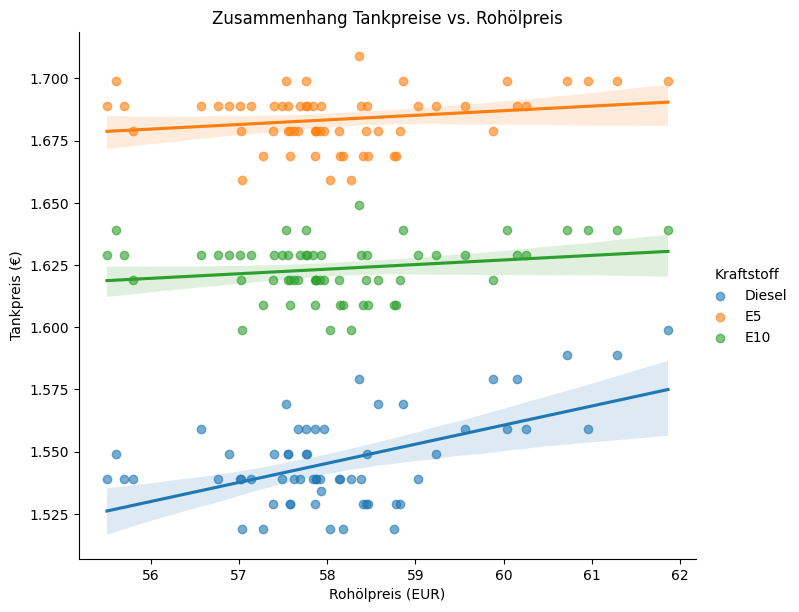

Korrelation Diesel vs. Ölpreis: 0.5420144420635739
Korrelation E5 vs. Ölpreis: 0.21423362578604485
Korrelation E10 vs. Ölpreis: 0.21423362578604485


In [7]:

df_melted = df_daily_all.melt(id_vars='Oil_Price_EUR', value_vars=['Diesel','E5','E10'],
                              var_name='Kraftstoff', value_name='Preis')

sns.lmplot(data=df_melted, x='Oil_Price_EUR', y='Preis', hue='Kraftstoff', height=6, aspect=1.2, markers='o', scatter_kws={'alpha':0.6})
plt.xlabel("Rohölpreis (EUR)")
plt.ylabel("Tankpreis (€)")
plt.title("Zusammenhang Tankpreise vs. Rohölpreis")
plt.show()

# Korrelation Diesel vs. Rohölpreis
corr_diesel = df_daily_all['Diesel'].corr(df_daily_all['Oil_Price_EUR'])
print("Korrelation Diesel vs. Ölpreis:", corr_diesel)

# Korrelation E5 vs. Rohölpreis
corr_e5 = df_daily_all['E5'].corr(df_daily_all['Oil_Price_EUR'])
print("Korrelation E5 vs. Ölpreis:", corr_e5)

# Korrelation E10 vs. Rohölpreis
corr_e10 = df_daily_all['E10'].corr(df_daily_all['Oil_Price_EUR'])
print("Korrelation E10 vs. Ölpreis:", corr_e10)



Ergebnis: Bei jeder Kraftstoffart lässt sich eine positive Korrelation mit dem Rohölpreis erkennen. Besonders stark korreliert der Dieselpreis mit dem Rohölpreis. Ein Grund dafür ist, dass der variable Rohöl-Kostenanteil beim Diesel höher ist. Bei Benzin ist der steuerliche Fixanteil höher und hat dadurch eine niedrigere Korrelation. Außerdem entkoppelt der Ethanol-Anteil den Benzinpreis vom Rohölpreis.

## Erstellung von Sampling-Datensätzen

Für die zukünftige Arbeit in diesem Projekt werden mehrere Sampling-Datensätze erstellt, die die Tankerkönig-Daten bereits in einem aggregierten Zustand bereitstellen. Die Idee entstand, weil das Arbeiten mit den Rohdaten aus tankerkoenig_historic.py performance- und zeittechnisch sehr aufwendig ist.

Gearbeitet wird mit dem Jahr 2024, da dies der aktuellste Zeitraum ist, für den vollständige Daten für ein ganzes Jahr vorliegen. Ein einzelnes Jahr wird als ausreichend angesehen, weil es typische saisonale Muster wie Sommer- und Wintereffekte, Ferienund Marktvolatilität vollständig abbildet. Damit entsteht ein Datensatz, der bewusst komprimiert, aber nicht verzerrt ist: Die wesentlichen Strukturen bleiben erhalten, während die Menge für Analysezwecke handhabbar bleibt.

Die Daten werden nach PLZ-1 Regionen (0xxxx–9xxxx) gefiltert. Diese Einteilung bietet genügend Variation für regionale Vergleiche, bleibt aber kompakt genug, um die Datenmenge stark zu reduzieren. Zusätzlich wird als Fokusregion die PLZ-2 Region 70xxx genutzt, da sie den Großraum Stuttgart abbildet, auf den sich die spätere Endprognose konzentriert. Durch die Kombination aus PLZ-1 (breite Vergleichbarkeit) und PLZ-2 (Fokusregion) entsteht ein klar strukturierter Analyseansatz.

Folgende statistische Aggregationen sollen als Sampling-Datensätze verfügbar sein (auf jeweils jeden einzelnen Kraftstoff):
- täglicher Medianpreis
- Tagesminimum
- Tagesmaximum
- Perzentil (P10)
- Perzentil (P90)
- Rolling Median über 3 Tage

Diese Kennzahlen decken sowohl typische zentrale Tendenzen (Median), als auch die Streuung in der Preisverteilung (P10/P90) und kurzfristige Trends (Rolling Median) ab.

Folgende zusätzliche Anforderung wird definiert:
- Die Daten werden als Parquet-Cache-Dateien gespeichert, da dieses Format wesentlich performanter ist als klassische CSV-Dateien. Die Nutzung eines Cache-Formats stellt sicher, dass alle Teammitglieder jederzeit auf die identische und überprüfbare Datengrundlage zugreifen können, was die Reproduzierbarkeit innerhalb des Projekts erhöht. CSV-Dateien werden optional zusätzlich zur Nachvollziehbarkeit bereitgestellt.
- Zwischenrgebnisse (DFs) werden zusätzlich zu den Roh-Parquet-Dateien (Basis für Datei-Benennung) auch im Output als Cache gespeichert. Bennenung erfolgt analog zu den DFs im Code, also zusätzlich Aggregations- oder Filterungsmerkmal.

Die Daten werden in 4 Schritten (jeweils immer 3 Monate) geladen und aufbereitet, damit nich zu viele Daten auf einmal geladen werden. Erfahrungsgemäß ergeben sich bei mehr als 3 Monaten technische Schwirigkeiten bei den dafür benutzten Rechnerkapazitäten.

In [2]:
from data.data_retrevial.tankerkoenig_historic import get_tankerkoenig_historic

#### Rohdaten initialisieren (Quartal 1)

In [3]:
tankdaten_long_1_df = get_tankerkoenig_historic(
    start_date_str="2024-01-01",
    end_date_str="2024-03-31",
    resolve_uuids=True)

tankdaten_long_1_df.head(20)

,Datum_Uhrzeit,Stations_ID,Diesel,E5,E10,Name,PLZ
0,2024-01-01 00:00:19+01:00,bba11e4c-d711-4e59-a84a-d0c660a416b8,1.729,1.799,1.739,Varel II,26316
1,2024-01-01 00:00:19+01:00,1ca2cd6c-c5f7-43fb-87ba-84064faf7e42,1.659,1.739,1.679,NÜRNBERG - SCHANZAECKER STRASSE 7-9,90443
2,2024-01-01 00:01:20+01:00,7a648916-974a-40d6-a6f5-7db1ce382564,1.659,1.729,1.669,"TS Melle, Oldendorfer Straße",49324
3,2024-01-01 00:01:20+01:00,a9777311-b4b8-4201-bccd-dfc6ae4a9557,1.679,1.779,1.729,AVIA Tankstelle,91613
4,2024-01-01 00:01:20+01:00,6e6481ca-530c-4cfd-b5cf-2250c71c7d56,1.669,1.769,1.709,Ratio Münster - Gievenbeck,48161
5,2024-01-01 00:01:20+01:00,2b44c5b6-3db1-43e8-ab2c-4ea58036bc2e,1.679,1.749,1.689,Freie Tankstelle,26203
6,2024-01-01 00:01:20+01:00,ac71410b-f672-4f24-b897-ee4d9536e20e,1.644,1.724,1.664,AVIA Tankstelle,32758
7,2024-01-01 00:01:20+01:00,d042965a-c52b-4fa8-a6c0-bbde94ea6c69,1.659,1.769,1.839,Knies+Lagotka Kartentankstelle,35114
8,2024-01-01 00:01:20+01:00,517b6498-4e63-42b5-9cc6-c79c4255e8fd,1.599,1.699,0.000,Schrepfer Mineralöl und Brennstoff GmbH,96250
9,2024-01-01 00:01:20+01:00,91900560-679e-46c3-9bb0-7ceaf1a8e5e0,1.659,1.729,1.669,"TS, Industriestraße",49324


#### Rohdaten initialisieren (Quartal 2)

In [4]:
tankdaten_long_2_df = get_tankerkoenig_historic(
    start_date_str="2024-04-01",
    end_date_str="2024-06-30",
    resolve_uuids=True)

tankdaten_long_2_df

,Datum_Uhrzeit,Stations_ID,Diesel,E5,E10,Name,PLZ
0,2024-04-01 00:00:34+02:00,db307731-f6c4-4c45-9af4-1058e9b23397,1.709,1.839,1.779,AVIA Tankstelle,90453
1,2024-04-01 00:00:34+02:00,6bb23c12-f7ce-41a8-ad1c-b50854808fe9,1.699,1.779,1.719,AVIA Tankstelle,74706
2,2024-04-01 00:00:34+02:00,c7f687c8-5718-49d0-88b0-092c55aeb9a4,1.689,1.879,1.819,Knies + Lagotka Tankpool24,35039
3,2024-04-01 00:00:34+02:00,c1a1a169-d0b9-4e6a-a9a0-a44c4065e8f7,1.829,1.959,1.899,Aral Tankstelle,12529
4,2024-04-01 00:00:34+02:00,a9994385-741f-4374-b738-d33681e101a7,1.699,1.879,1.819,Raisa eG,29640
...,...,...,...,...,...,...,...
36064618,2024-06-30 23:57:10+02:00,d4969cf8-baba-4364-a2b8-59b544ad00ce,1.659,1.819,1.759,AVIA Xpress Automatenstation Deggenhausertal,88693
36064619,2024-06-30 23:58:12+02:00,0338d6c7-e26d-42aa-af00-54fc02553df4,1.639,1.819,1.759,Turbo Tankstelle Oberndorf,78727
36064620,2024-06-30 23:58:12+02:00,d042965a-c52b-4fa8-a6c0-bbde94ea6c69,1.649,1.819,1.729,Knies+Lagotka Kartentankstelle,35114
36064621,2024-06-30 23:58:12+02:00,a2c299b4-8524-4b8c-83db-dbfe5b9fafe0,1.729,1.859,1.799,"Lengede (38268), Wolfenbütteler Str. 59",38268


#### Rohdaten initialisieren (Quartal 3)

In [5]:
tankdaten_long_3_df = get_tankerkoenig_historic(
    start_date_str="2024-07-01",
    end_date_str="2024-09-30",
    resolve_uuids=True)

tankdaten_long_3_df

,Datum_Uhrzeit,Stations_ID,Diesel,E5,E10,Name,PLZ
0,2024-07-01 00:00:13+02:00,43a14d7b-6968-4e88-bfe8-a9122bb7d6fe,1.669,1.849,1.789,"bft-Tankstelle Förster, Steinau",36396
1,2024-07-01 00:00:13+02:00,fee18acb-5b95-495c-be44-cc21a44c4b6b,1.659,1.819,1.759,AVIA Tankstelle,90559
2,2024-07-01 00:00:13+02:00,6dc60a74-b1ed-4d28-64b2-3b25abcd30b6,1.649,1.829,1.769,24h Tankautomat Albers,26169
3,2024-07-01 00:00:13+02:00,0905ac3b-ad74-46fa-bb27-18e55973a3c8,1.699,1.869,1.809,LBD-Calveslage,49377
4,2024-07-01 00:00:13+02:00,9a265748-f72d-11ee-89da-005056a27fa7,1.599,1.789,1.719,CLASSIC Hofgeismar,34369
...,...,...,...,...,...,...,...
37518363,2024-09-30 23:59:06+02:00,e11f150d-dddc-417f-9ce6-1d0252c3c717,1.519,1.659,1.599,AVIA Tankstelle,81669
37518364,2024-09-30 23:59:06+02:00,57f207da-80a0-4e61-b98d-d6eef0d79cfe,1.489,1.669,1.609,AVIA Tankstelle,50170
37518365,2024-09-30 23:59:06+02:00,a40f8609-356c-4a23-9a21-97ec53b79ce8,1.509,1.689,1.629,AVIA Tankstelle,36391
37518366,2024-09-30 23:59:06+02:00,6dc60a74-b1ed-4d28-64b2-3b25abcd30b6,1.509,1.639,1.579,24h Tankautomat Albers,26169


#### Rohdaten initialisieren (Quartal 4)

In [6]:
tankdaten_long_4_df = get_tankerkoenig_historic(
    start_date_str="2024-10-01",
    end_date_str="2024-12-31",
    resolve_uuids=True)

tankdaten_long_4_df

,Datum_Uhrzeit,Stations_ID,Diesel,E5,E10,Name,PLZ
0,2024-10-01 00:00:06+02:00,163f01c1-13be-42c2-b9ac-2c2764ea9779,1.529,1.639,1.579,Esso Tankstelle,13597
1,2024-10-01 00:00:06+02:00,ce97aed5-069a-4494-837e-c18e083547c6,1.459,1.609,1.549,Esso Tankstelle,76456
2,2024-10-01 00:00:06+02:00,aa0ed2d6-3f63-487a-9a89-4a0a2dafa5bf,1.529,1.689,1.629,Esso Tankstelle,57080
3,2024-10-01 00:00:06+02:00,37a40b86-8ade-45c5-aae1-4ebbab5188fc,1.509,1.669,1.609,Esso Tankstelle,55129
4,2024-10-01 00:00:06+02:00,bf178dbd-0da0-4412-a665-9a9362646ed2,1.519,1.659,1.599,Esso Tankstelle,76689
...,...,...,...,...,...,...,...
40245768,2024-12-31 23:59:28+01:00,a2c299b4-8524-4b8c-83db-dbfe5b9fafe0,1.689,1.799,1.739,"Lengede (38268), Wolfenbütteler Str. 59",38268
40245769,2024-12-31 23:59:28+01:00,91bf65f2-1d6b-459b-22f0-f861c59e69e7,1.639,1.779,1.719,Heinrich Albers OHG,26349
40245770,2024-12-31 23:59:28+01:00,db307731-f6c4-4c45-9af4-1058e9b23397,1.599,1.719,1.659,AVIA Tankstelle,90453
40245771,2024-12-31 23:59:28+01:00,d4ad9294-e903-4281-a40f-f08cea841392,1.579,1.699,0.000,Buch Ahorn,74744


#### Filterung

##### PLZ-2 70xxx

Quartal 1

In [7]:
tankdaten_long_1_plz70_df = tankdaten_long_1_df[tankdaten_long_1_df['PLZ'].str.startswith('70')]

# Ausgabe des gefilterten DataFrames
tankdaten_long_1_plz70_df

,Datum_Uhrzeit,Stations_ID,Diesel,E5,E10,Name,PLZ
49,2024-01-01 00:03:51+01:00,6ee8b57b-cb9c-4414-be27-06204e0a89cc,1.759,1.849,1.789,Sprint,70437
275,2024-01-01 00:05:53+01:00,b52168ad-38e0-4f72-900e-7ab6e96cc1be,1.769,1.859,1.799,Aral Tankstelle,70806
346,2024-01-01 00:05:53+01:00,42660742-90cb-4cb8-b71a-64d8cfe343b5,1.789,1.859,1.799,Aral Tankstelle,70327
517,2024-01-01 00:05:53+01:00,9f783258-e896-4dfe-83f5-ae7f53a6097f,1.759,1.859,1.799,Aral Tankstelle,70563
561,2024-01-01 00:05:53+01:00,c890b8e5-eba1-46c9-abbc-53e321feaaa4,1.759,1.859,1.799,Aral Tankstelle,70374
...,...,...,...,...,...,...,...
33232535,2024-03-31 23:24:23+02:00,cb1f0588-d517-40f0-8ce3-3edadebea40d,1.709,1.819,1.759,OMV Tankstelle,70597
33232545,2024-03-31 23:24:23+02:00,507e6415-581e-44f8-b090-11d9e1b7af11,1.719,1.859,1.799,AVIA Tankstelle,70565
33233161,2024-03-31 23:38:41+02:00,51d4b4ec-a095-1aa0-e100-80009459e03a,1.669,1.769,1.709,JET FELLBACH SCHORNDORFER STR. 37,70736
33233196,2024-03-31 23:39:43+02:00,217f20c6-d2f7-4f93-a038-71ba66009638,1.679,1.779,1.719,ENI,70734


Quartal 2

In [8]:
tankdaten_long_2_plz70_df = tankdaten_long_2_df[tankdaten_long_2_df['PLZ'].str.startswith('70')]

# Ausgabe des gefilterten DataFrames
tankdaten_long_2_plz70_df

,Datum_Uhrzeit,Stations_ID,Diesel,E5,E10,Name,PLZ
469,2024-04-01 00:46:30+02:00,7d3476b2-6a52-41b8-90cf-90178ab53936,1.689,1.849,1.789,TotalEnergies Filderstadt-Harth,70794
480,2024-04-01 00:46:30+02:00,84b22247-3390-4e2e-9be5-ef6d7aa27d80,1.729,1.849,1.789,TotalEnergies Stuttgart,70188
562,2024-04-01 00:46:30+02:00,d63262ee-9abd-4b66-808a-7d85e64f51cd,1.659,1.759,1.699,TotalEnergies Fellbach,70736
594,2024-04-01 00:51:36+02:00,f9a0f8fe-63b2-43e7-8bfe-898cb0a394cf,1.719,1.839,1.779,RAN Station,70327
601,2024-04-01 00:52:37+02:00,855e5469-1572-4e20-a984-c351cca5d2b5,1.759,1.869,1.809,AVIA XPress Automatenstation Stuttgart-Wangen,70188
...,...,...,...,...,...,...,...
36064239,2024-06-30 23:38:45+02:00,217f20c6-d2f7-4f93-a038-71ba66009638,1.659,1.809,1.749,ENI,70734
36064242,2024-06-30 23:38:45+02:00,34842f36-dffe-49c5-bb02-ab074e1f14e6,1.659,1.809,1.749,ENI,70327
36064318,2024-06-30 23:39:46+02:00,93b1876f-cee8-4187-a4d4-b5b000e2bf41,1.649,1.809,1.749,OMV Tankstelle,70629
36064459,2024-06-30 23:46:59+02:00,6845d53c-13a9-4dd9-5c27-cc1557e81a76,1.639,1.789,1.729,MTB Tankstelle Fellbach,70736


Quartal 3

In [9]:
tankdaten_long_3_plz70_df = tankdaten_long_3_df[tankdaten_long_3_df['PLZ'].str.startswith('70')]

# Ausgabe des gefilterten DataFrames
tankdaten_long_3_plz70_df

,Datum_Uhrzeit,Stations_ID,Diesel,E5,E10,Name,PLZ
334,2024-07-01 00:44:40+02:00,d63262ee-9abd-4b66-808a-7d85e64f51cd,1.679,1.819,1.759,TotalEnergies Fellbach,70736
508,2024-07-01 00:44:40+02:00,7d3476b2-6a52-41b8-90cf-90178ab53936,1.679,1.839,1.779,TotalEnergies Filderstadt-Harth,70794
520,2024-07-01 00:44:40+02:00,84b22247-3390-4e2e-9be5-ef6d7aa27d80,1.669,1.819,1.759,TotalEnergies Stuttgart,70188
610,2024-07-01 00:45:41+02:00,f9a0f8fe-63b2-43e7-8bfe-898cb0a394cf,1.659,1.809,1.749,RAN Station,70327
638,2024-07-01 00:49:49+02:00,855e5469-1572-4e20-a984-c351cca5d2b5,1.699,1.839,1.779,AVIA XPress Automatenstation Stuttgart-Wangen,70188
...,...,...,...,...,...,...,...
37517650,2024-09-30 23:38:44+02:00,51d4b4ec-a095-1aa0-e100-80009459e03a,1.509,1.649,1.589,JET FELLBACH SCHORNDORFER STR. 37,70736
37517930,2024-09-30 23:42:48+02:00,8d66b8be-5037-4822-8ab4-1aa7b3b8a657,1.489,1.629,1.569,Esso Tankstelle,70794
37518115,2024-09-30 23:43:49+02:00,93b1876f-cee8-4187-a4d4-b5b000e2bf41,1.489,1.659,1.599,OMV Tankstelle,70629
37518128,2024-09-30 23:43:49+02:00,7230f70a-c543-4227-aad3-e809b99ffd7b,1.529,1.669,1.609,Esso Tankstelle,70197


Quartal 4

In [10]:
tankdaten_long_4_plz70_df = tankdaten_long_4_df[tankdaten_long_4_df['PLZ'].str.startswith('70')]

# Ausgabe des gefilterten DataFrames
tankdaten_long_4_plz70_df

,Datum_Uhrzeit,Stations_ID,Diesel,E5,E10,Name,PLZ
120,2024-10-01 00:08:15+02:00,6587d08a-538c-4205-ac7f-7156d70dc1e6,1.589,1.719,1.659,STUTTGART - NUERNBERGER STR.,70374
127,2024-10-01 00:08:15+02:00,f9f33d1b-3959-499c-b696-caaa9567f31a,1.559,1.719,1.659,ENI,70469
398,2024-10-01 00:45:56+02:00,d63262ee-9abd-4b66-808a-7d85e64f51cd,1.519,1.659,1.599,TotalEnergies Fellbach,70736
593,2024-10-01 00:45:56+02:00,7d3476b2-6a52-41b8-90cf-90178ab53936,1.499,1.649,1.589,TotalEnergies Filderstadt-Harth,70794
605,2024-10-01 00:45:56+02:00,84b22247-3390-4e2e-9be5-ef6d7aa27d80,1.529,1.669,1.609,TotalEnergies Stuttgart,70188
...,...,...,...,...,...,...,...
40245372,2024-12-31 23:38:09+01:00,6587d08a-538c-4205-ac7f-7156d70dc1e6,1.619,1.729,1.669,STUTTGART - NUERNBERGER STR.,70374
40245374,2024-12-31 23:38:09+01:00,34842f36-dffe-49c5-bb02-ab074e1f14e6,1.619,1.729,1.669,ENI,70327
40245382,2024-12-31 23:38:09+01:00,217f20c6-d2f7-4f93-a038-71ba66009638,1.619,1.729,1.669,ENI,70734
40245559,2024-12-31 23:43:14+01:00,93b1876f-cee8-4187-a4d4-b5b000e2bf41,1.599,1.719,1.659,Esso Station,70629


Zusammenfügen zu gefilterten (PLZ-2 70xxx) Tankpreis-Messungen im Jahr 2024:

In [11]:
import pandas as pd

tankdaten_long_2024_plz70_df = pd.concat([
    tankdaten_long_1_plz70_df,
    tankdaten_long_2_plz70_df,
    tankdaten_long_3_plz70_df,
    tankdaten_long_4_plz70_df
])

In [12]:
tankdaten_long_2024_plz70_df.head()

,Datum_Uhrzeit,Stations_ID,Diesel,E5,E10,Name,PLZ
49,2024-01-01 00:03:51+01:00,6ee8b57b-cb9c-4414-be27-06204e0a89cc,1.759,1.849,1.789,Sprint,70437
275,2024-01-01 00:05:53+01:00,b52168ad-38e0-4f72-900e-7ab6e96cc1be,1.769,1.859,1.799,Aral Tankstelle,70806
346,2024-01-01 00:05:53+01:00,42660742-90cb-4cb8-b71a-64d8cfe343b5,1.789,1.859,1.799,Aral Tankstelle,70327
517,2024-01-01 00:05:53+01:00,9f783258-e896-4dfe-83f5-ae7f53a6097f,1.759,1.859,1.799,Aral Tankstelle,70563
561,2024-01-01 00:05:53+01:00,c890b8e5-eba1-46c9-abbc-53e321feaaa4,1.759,1.859,1.799,Aral Tankstelle,70374


In [13]:
len(tankdaten_long_2024_plz70_df)

1260053

In [14]:
tankdaten_long_2024_plz70_df.to_parquet('data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz70.parquet')

##### PLZ-1-Regionen (0-9)

Quartal 1

In [15]:
# Schleife durchläuft 10 mal von 0-9 (PLZ-1er-Stelle) 
for i in range(10):
    prefix = str(i)

# Erstellt DFs für jede PLZ-1er-Stelle und speichert diese als separate Parquet-Datei
    tankdaten_long_1_plzx_df = tankdaten_long_1_df[tankdaten_long_1_df['PLZ'].str.startswith(prefix)]

    filename = f"data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz{prefix}x.parquet"

    tankdaten_long_1_plzx_df.to_parquet(filename)

# Ausgabe zur Prüfung
    print(f"Gespeichert: {filename} – {len(tankdaten_long_1_plzx_df)} Zeilen")


Gespeichert: data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz0x.parquet – 2433404 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz1x.parquet – 2370787 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz2x.parquet – 4292952 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz3x.parquet – 4397300 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz4x.parquet – 4147365 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz5x.parquet – 3560162 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz6x.parquet – 2866149 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz7x.parquet – 3381584 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz8x.parquet – 2667405 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz9x.parqu

Quartal 2

In [17]:
# Schleife durchläuft 10 mal von 0-9 (PLZ-1er-Stelle) 
for i in range(10):
    prefix = str(i)

# Erstellt DFs für jede PLZ-1er-Stelle und speichert diese als separate Parquet-Datei
    tankdaten_long_2_plzx_df = tankdaten_long_2_df[tankdaten_long_2_df['PLZ'].str.startswith(prefix)]

    filename = f"data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz{prefix}x.parquet"

    tankdaten_long_2_plzx_df.to_parquet(filename)

# Ausgabe zur Prüfung
    print(f"Gespeichert: {filename} – {len(tankdaten_long_2_plzx_df)} Zeilen")


Gespeichert: data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz0x.parquet – 2560244 Zeilen
Gespeichert: data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz1x.parquet – 2477633 Zeilen
Gespeichert: data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz2x.parquet – 4594022 Zeilen
Gespeichert: data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz3x.parquet – 4581592 Zeilen
Gespeichert: data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz4x.parquet – 4494510 Zeilen
Gespeichert: data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz5x.parquet – 3910832 Zeilen
Gespeichert: data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz6x.parquet – 3072148 Zeilen
Gespeichert: data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz7x.parquet – 3825079 Zeilen
Gespeichert: data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz8x.parquet – 3064661 Zeilen
Gespeichert: data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz9x.parqu

Quartal 3

In [18]:
# Schleife durchläuft 10 mal von 0-9 (PLZ-1er-Stelle) 
for i in range(10):
    prefix = str(i)

# Erstellt DFs für jede PLZ-1er-Stelle und speichert diese als separate Parquet-Datei
    tankdaten_long_3_plzx_df = tankdaten_long_3_df[tankdaten_long_3_df['PLZ'].str.startswith(prefix)]

    filename = f"data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz{prefix}x.parquet"

    tankdaten_long_3_plzx_df.to_parquet(filename)

# Ausgabe zur Prüfung
    print(f"Gespeichert: {filename} – {len(tankdaten_long_3_plzx_df)} Zeilen")

Gespeichert: data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz0x.parquet – 2646521 Zeilen
Gespeichert: data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz1x.parquet – 2639103 Zeilen
Gespeichert: data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz2x.parquet – 4912626 Zeilen
Gespeichert: data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz3x.parquet – 4755250 Zeilen
Gespeichert: data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz4x.parquet – 4651697 Zeilen
Gespeichert: data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz5x.parquet – 4092850 Zeilen
Gespeichert: data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz6x.parquet – 3169987 Zeilen
Gespeichert: data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz7x.parquet – 3924111 Zeilen
Gespeichert: data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz8x.parquet – 3133331 Zeilen
Gespeichert: data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz9x.parqu

Quartal 4

In [19]:
# Schleife durchläuft 10 mal von 0-9 (PLZ-1er-Stelle) 
for i in range(10):
    prefix = str(i)

# Erstellt DFs für jede PLZ-1er-Stelle und speichert diese als separate Parquet-Datei
    tankdaten_long_4_plzx_df = tankdaten_long_4_df[tankdaten_long_4_df['PLZ'].str.startswith(prefix)]

    filename = f"data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz{prefix}x.parquet"

    tankdaten_long_4_plzx_df.to_parquet(filename)
# Ausgabe zur Prüfung
    print(f"Gespeichert: {filename} – {len(tankdaten_long_4_plzx_df)} Zeilen")

Gespeichert: data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz0x.parquet – 2949363 Zeilen
Gespeichert: data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz1x.parquet – 2889568 Zeilen
Gespeichert: data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz2x.parquet – 5277789 Zeilen
Gespeichert: data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz3x.parquet – 5228475 Zeilen
Gespeichert: data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz4x.parquet – 5097043 Zeilen
Gespeichert: data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz5x.parquet – 4321929 Zeilen
Gespeichert: data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz6x.parquet – 3325656 Zeilen
Gespeichert: data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz7x.parquet – 4098841 Zeilen
Gespeichert: data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz8x.parquet – 3225228 Zeilen
Gespeichert: data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz9x.parqu

Zusammenfügen zu gefilterten (PLZ-2 70xxx) Tankpreis-Messungen im Jahr 2024:

In [20]:
# Schleife durchläuft 10 mal von 0-9 (PLZ-1er-Stelle) 
for i in range(10):
    prefix = str(i)

    filename_1 = f"data/output/cache_2024-01-01_to_2024-03-31_uuids_resolved_plz{prefix}x.parquet"
    filename_2 = f"data/output/cache_2024-04-01_to_2024-06-30_uuids_resolved_plz{prefix}x.parquet"
    filename_3 = f"data/output/cache_2024-07-01_to_2024-09-30_uuids_resolved_plz{prefix}x.parquet"
    filename_4 = f"data/output/cache_2024-10-01_to_2024-12-31_uuids_resolved_plz{prefix}x.parquet"

    tankdaten_long_2024_plzx_df = pd.concat([
        pd.read_parquet(filename_1),
        pd.read_parquet(filename_2),
        pd.read_parquet(filename_3),
        pd.read_parquet(filename_4)
    ])

    filename_2024 = f"data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz{prefix}x.parquet"
    tankdaten_long_2024_plzx_df.to_parquet(filename_2024)

# Ausgabe zur Prüfung
    print(f"Gespeichert: {filename_2024} – {len(tankdaten_long_2024_plzx_df)} Zeilen")

Gespeichert: data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz0x.parquet – 10589532 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz1x.parquet – 10377091 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz2x.parquet – 19077389 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz3x.parquet – 18962617 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz4x.parquet – 18390615 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz5x.parquet – 15885773 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz6x.parquet – 12433940 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz7x.parquet – 15229615 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz8x.parquet – 12090625 Zeilen
Gespeichert: data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_pl

### Aggregationen und Statistiken

Gegeben:
Alle gefilterten DFs für das ganze Jahr 2024:

- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz70**.parquet
- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz0x**.parquet – 10589532 Zeilen
- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz1x**.parquet – 10377091 Zeilen
- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz2x**.parquet – 19077389 Zeilen
- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz3x**.parquet – 18962617 Zeilen
- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz4x**.parquet – 18390615 Zeilen
- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz5x**.parquet – 15885773 Zeilen
- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz6x**.parquet – 12433940 Zeilen
- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz7x**.parquet – 15229615 Zeilen
- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz8x**.parquet – 12090625 Zeilen
- data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_**plz9x**.parquet – 14024385 Zeilen

### Gewünschte Aggregationen

- täglicher Medianpreis
- Tagesminimum
- Tagesmaximum
- Perzentil (P10)
- Perzentil (P90)
- Rolling Median über 3 Tage

#### PLZ-70

In [27]:
filename = "data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz70.parquet"

tankdaten_long_2024_plz70_df = pd.read_parquet(filename)

len(tankdaten_long_2024_plz70_df)

1260053

PLZ-70 - täglicher Median

In [28]:
tankdaten_long_2024_plz70_df['date'] = tankdaten_long_2024_plz70_df['Datum_Uhrzeit'].dt.date
tankdaten_long_2024_plz70_med1_df = tankdaten_long_2024_plz70_df.groupby('date')[['Diesel', 'E5', 'E10']].median().reset_index()

tankdaten_long_2024_plz70_med1_df.to_parquet("data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz70_med1.parquet")

print(tankdaten_long_2024_plz70_med1_df.tail())
print(f"Länge des DataFrames: {len(tankdaten_long_2024_plz70_med1_df)}")

           date  Diesel     E5    E10
361  2024-12-27   1.609  1.709  1.649
362  2024-12-28   1.589  1.699  1.639
363  2024-12-29   1.609  1.709  1.649
364  2024-12-30   1.619  1.719  1.659
365  2024-12-31   1.629  1.719  1.659
Länge des DataFrames: 366


PLZ-70 - täglicher Minimum

In [29]:
tankdaten_long_2024_plz70_df['date'] = tankdaten_long_2024_plz70_df['Datum_Uhrzeit'].dt.date
tankdaten_long_2024_plz70_min_df = tankdaten_long_2024_plz70_df.groupby('date')[['Diesel', 'E5', 'E10']].min().reset_index()

tankdaten_long_2024_plz70_min_df.to_parquet("data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz70_min.parquet")

print(tankdaten_long_2024_plz70_min_df.tail())
print(f"Länge des DataFrames: {len(tankdaten_long_2024_plz70_min_df)}")

           date  Diesel     E5    E10
361  2024-12-27   1.479  1.589  1.529
362  2024-12-28   1.479  1.589  1.529
363  2024-12-29   1.499  1.639  1.579
364  2024-12-30   1.499  1.639  1.579
365  2024-12-31   1.529  1.639  1.589
Länge des DataFrames: 366


PLZ-70 - täglicher Maximum

In [30]:
tankdaten_long_2024_plz70_df['date'] = tankdaten_long_2024_plz70_df['Datum_Uhrzeit'].dt.date
tankdaten_long_2024_plz70_max_df = tankdaten_long_2024_plz70_df.groupby('date')[['Diesel', 'E5', 'E10']].max().reset_index()

tankdaten_long_2024_plz70_max_df.to_parquet("data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz70_max.parquet")

print(tankdaten_long_2024_plz70_max_df.tail())
print(f"Länge des DataFrames: {len(tankdaten_long_2024_plz70_max_df)}")

           date  Diesel     E5    E10
361  2024-12-27   1.779  1.879  1.819
362  2024-12-28   1.779  1.879  1.819
363  2024-12-29   1.779  1.889  1.829
364  2024-12-30   1.779  1.889  1.829
365  2024-12-31   1.789  1.889  1.829
Länge des DataFrames: 366


PLZ-70 - Perzentil P10

In [31]:
tankdaten_long_2024_plz70_df['date'] = tankdaten_long_2024_plz70_df['Datum_Uhrzeit'].dt.date
tankdaten_long_2024_plz70_p10_df = tankdaten_long_2024_plz70_df.groupby('date')[['Diesel', 'E5', 'E10']].quantile(0.1).reset_index()

tankdaten_long_2024_plz70_p10_df.to_parquet("data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz70_p10.parquet")

print(tankdaten_long_2024_plz70_p10_df.tail())
print(f"Länge des DataFrames: {len(tankdaten_long_2024_plz70_p10_df)}")

           date  Diesel     E5    E10
361  2024-12-27   1.559  1.669  1.609
362  2024-12-28   1.549  1.659  1.599
363  2024-12-29   1.569  1.669  1.609
364  2024-12-30   1.569  1.679  1.619
365  2024-12-31   1.579  1.679  1.619
Länge des DataFrames: 366


PLZ-70 - Perzentil P90

In [32]:
tankdaten_long_2024_plz70_df['date'] = tankdaten_long_2024_plz70_df['Datum_Uhrzeit'].dt.date
tankdaten_long_2024_plz70_p90_df = tankdaten_long_2024_plz70_df.groupby('date')[['Diesel', 'E5', 'E10']].quantile(0.9).reset_index()

tankdaten_long_2024_plz70_p90_df.to_parquet("data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz70_p90.parquet")

print(tankdaten_long_2024_plz70_p90_df.tail())
print(f"Länge des DataFrames: {len(tankdaten_long_2024_plz70_p90_df)}")

           date  Diesel     E5    E10
361  2024-12-27   1.689  1.789  1.729
362  2024-12-28   1.649  1.749  1.689
363  2024-12-29   1.659  1.779  1.719
364  2024-12-30   1.689  1.789  1.729
365  2024-12-31   1.699  1.799  1.739
Länge des DataFrames: 366


PLZ-70 - Rolling Median über 3 Tage

In [33]:
tankdaten_long_2024_plz70_df['date'] = tankdaten_long_2024_plz70_df['Datum_Uhrzeit'].dt.date
tankdaten_long_2024_plz70_med3_df = tankdaten_long_2024_plz70_df.groupby('date')[['Diesel', 'E5', 'E10']].median().rolling(window=3).median().reset_index()

tankdaten_long_2024_plz70_med3_df.to_parquet("data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz70_med3.parquet")

print(tankdaten_long_2024_plz70_med3_df.tail())
print(f"Länge des DataFrames: {len(tankdaten_long_2024_plz70_med3_df)}")

           date  Diesel     E5    E10
361  2024-12-27   1.609  1.719  1.659
362  2024-12-28   1.609  1.709  1.649
363  2024-12-29   1.609  1.709  1.649
364  2024-12-30   1.609  1.709  1.649
365  2024-12-31   1.619  1.719  1.659
Länge des DataFrames: 366


#### PLZ-x (0-9)

Alle Aggregationen:

In [ ]:
import pandas as pd

# Spalten, die aggregiert werden sollen
cols = ['Diesel', 'E5', 'E10']

# Definition der Aggregationen (Name: Funktion)
aggs = {
    'med1': lambda df: df.groupby('date')[cols].median().reset_index(),
    'min1': lambda df: df.groupby('date')[cols].min().reset_index(),
    'max1': lambda df: df.groupby('date')[cols].max().reset_index(),
    'p10':  lambda df: df.groupby('date')[cols].quantile(0.10).reset_index(),
    'p90':  lambda df: df.groupby('date')[cols].quantile(0.90).reset_index(),
    'med3': lambda df: df.groupby('date')[cols].median().rolling(window=3).median().reset_index()
}

# Schleife über Postleitzahlen 0 bis 9
for i in range(10):
    prefix = str(i)
    
    # 1. Einlesen der Jahres-Datei
    filename_in = f"data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz{prefix}x.parquet"
    tankdaten_long_2024_plzx_df = pd.read_parquet(filename_in)
    
    # Datum vorbereiten
    tankdaten_long_2024_plzx_df['date'] = tankdaten_long_2024_plzx_df['Datum_Uhrzeit'].dt.date

    print(f"--- Verarbeite PLZ {prefix}x ---")

    # 2. Innere Schleife über die Aggregationen
    for suffix, func in aggs.items():
        # Berechnung ausführen
        tankdaten_agg_df = func(tankdaten_long_2024_plzx_df)
        
        # Speichern
        filename_out = f"data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz{prefix}x_{suffix}.parquet"
        tankdaten_agg_df.to_parquet(filename_out)
        
        print(f"  -> {filename_out} gespeichert ({len(tankdaten_agg_df)} Zeilen)")

--- Verarbeite PLZ 0x ---
  -> data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz0x_med1.parquet gespeichert (366 Zeilen)
  -> data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz0x_min1.parquet gespeichert (366 Zeilen)
  -> data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz0x_max1.parquet gespeichert (366 Zeilen)
  -> data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz0x_p10.parquet gespeichert (366 Zeilen)
  -> data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz0x_p90.parquet gespeichert (366 Zeilen)
  -> data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz0x_med3.parquet gespeichert (366 Zeilen)
--- Verarbeite PLZ 1x ---
  -> data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz1x_med1.parquet gespeichert (366 Zeilen)
  -> data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz1x_min1.parquet gespeichert (366 Zeilen)
  -> data/output/cache_2024-01-01_to_2024-12-31_uuids_resolved_plz1x_max1.parquet gespeichert 